### Import Libraries and Packages

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization, LayerNormalization, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

2024-06-05 14:45:29.194910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 14:45:29.195036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 14:45:29.324811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Basic data analysis

In [2]:
# 1. Read the data and inspect first 10 rows
file_path = "/kaggle/input/phrase-data/phrases_data.txt"
data = pd.read_csv(file_path, sep='\t', names=['phrases'])
data.head(10)

,phrases
0,Let's try something.
1,I have to go to sleep.
2,Today is June 18th and it is Muiriel's birthday!
3,Muiriel is 20 now.
4,"The password is ""Muiriel""."
5,I will be back soon.
6,I'm at a loss for words.
7,This is never going to end.
8,I just don't know what to say.
9,That was an evil bunny.


In [3]:
print(f"Total of {data.shape[0]} sentences")

Total of 10000 sentences


In [4]:
# 2. Clean training data
def clean_data(data):
    # Remove punctuation at the end
    data['cleaned'] = data['phrases'].apply(lambda x: re.sub(r'[.!?]+$', '', x))

    # # Convert to lowercase
    # data['cleaned'] = data['cleaned'].str.lower()

    # Remove whitespace
    data['cleaned'] = data['cleaned'].str.strip()

    # # Remove stop words
    # stop_words = set(stopwords.words('english'))
    # data['cleaned'] = data['cleaned'].apply(lambda x:
    #                                         ' '.join([word for word in x.split()
    #                                         if word not in stop_words]))

    # # Lemmatization
    # lemmatizer = WordNetLemmatizer()
    # data['cleaned'] = data['cleaned'].apply(lambda x:
    #                                         ' '.join([lemmatizer.lemmatize(word)
    #                                         for word in x.split()]))
clean_data(data)
data.head(20)

,phrases,cleaned
0,Let's try something.,Let's try something
1,I have to go to sleep.,I have to go to sleep
2,Today is June 18th and it is Muiriel's birthday!,Today is June 18th and it is Muiriel's birthday
3,Muiriel is 20 now.,Muiriel is 20 now
4,"The password is ""Muiriel"".","The password is ""Muiriel"""
5,I will be back soon.,I will be back soon
6,I'm at a loss for words.,I'm at a loss for words
7,This is never going to end.,This is never going to end
8,I just don't know what to say.,I just don't know what to say
9,That was an evil bunny.,That was an evil bunny


### Tokenization

In [5]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(data['cleaned'])
total_words = len(tokenizer.word_index) + 1

print(f"Total number of words: {total_words}")
print(f"Word index of hello: {tokenizer.word_index['hello']}")

Total number of words: 7247
Word index of hello: 2732


In [6]:
# Next, create a list called `input_sequences` which creates the n_gram model.

# use `texts_to_sequences` method to convert each phrase into sequence of numbers
# For example: "I like apple" becomes [6, 49, 1996]
input_sequences = []
max_sequence_length = 0
for each_phrase in tqdm(data['cleaned']):
    token_list = tokenizer.texts_to_sequences([each_phrase])[0]
    token_list_len = len(token_list)
    if token_list_len > max_sequence_length:
        max_sequence_length = token_list_len
        
    if token_list_len <= 3:
        input_sequences.append(token_list)
        continue
        
    for i in range(3, token_list_len):
        # provide at least 3 words to predict the next word
        n_gram = token_list[:i+1]
        input_sequences.append(n_gram)

print(f"\nTotal input sequences: {len(input_sequences)}")
print(input_sequences[:2])
# print(tokenizer.word_index["let's"])
# print(tokenizer.word_index["try"])
# print(tokenizer.word_index["something"])
print(tokenizer.word_index["i"])
print(tokenizer.word_index["have"])
print(tokenizer.word_index["to"])
print(tokenizer.word_index["go"])

100%|██████████| 10000/10000 [00:00<00:00, 54701.37it/s]


Total input sequences: 51661
[[195, 227, 141], [6, 14, 4, 41]]
6
14
4
41


In [7]:
# pad sequences
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_length,
                                         padding='pre'))
print(input_sequences[:2])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 195 227 141]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   6  14   4  41]]


### Prepare training set, validation, and test set

In [8]:
# Split dataset into training, validation, and test sets

# Split the whole dataset into 80% training + 20% testing
train_data, test_data = train_test_split(input_sequences, test_size=0.2, random_state=42)

# Split the 80% training into 85% training + 15% validation
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
# assert len(train_data) - 0.8 * 0.85 * len(input_sequences) <= 5

(41328, 69)
(5166, 69)
(5167, 69)


In [9]:
sentence= ''
test_tokens = [393, 2846, 5, 1083]
for token in test_tokens:
    sentence += ' ' + tokenizer.index_word[token]
print(sentence)
print(train_data[0])

 everyone deserves a second
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  393 2846    5 1083]


In [10]:
# Next create label
def create_feature_and_label(input_data):
    features, labels = input_data[:, :-1], input_data[:,-1]
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)
    return features, one_hot_labels

train_data, train_labels = create_feature_and_label(train_data)
val_data, val_labels = create_feature_and_label(val_data)
test_data, test_labels = create_feature_and_label(test_data)

In [13]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
print(train_data[0])
print(train_labels[0][1083])
print(test_labels.shape)

(41328, 68)
(5166, 68)
(5167, 68)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  393 2846    5]
1.0
(5167, 7247)


### Bi-LSTM Neural Network Model training

In [12]:
def create_model(total_words, hidden_size, optimizer):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_length - 1))
    model.add(LSTM(hidden_size))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

# Function to decay the learning rate
def scheduler(epoch, lr):
    min_lr = 0.001  # Set the minimum learning rate
    if epoch < 10:
        return lr
    else:
        new_lr = lr * np.exp(-0.1)  # Decays the learning rate by 1% every epoch after the 10th
        return new_lr

# Set the initial learning rate
initial_learning_rate = 0.01

# Compile the model with an optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

lr_scheduler = LearningRateScheduler(scheduler)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/kaggle/working/model_lstm.keras"
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_categorical_accuracy',
    verbose=1)

model = create_model(total_words, hidden_size=128, optimizer=optimizer)
history = model.fit(train_data, train_labels, epochs=50, batch_size=64,
                    validation_data=(val_data, val_labels), 
                    callbacks=[lr_scheduler, callback], verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
643/646 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.0639 - loss: 6.8989
Epoch 1: val_categorical_accuracy improved from -inf to 0.11401, saving model to /kaggle/working/model_lstm.keras
646/646 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - categorical_accuracy: 0.0640 - loss: 6.8966 - val_categorical_accuracy: 0.1140 - val_loss: 6.1851 - learning_rate: 0.0100
Epoch 2/50
646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.1299 - loss: 5.6069
Epoch 2: val_categorical_accuracy improved from 0.11401 to 0.13879, saving model to /kaggle/working/model_lstm.keras
646/646 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.1299 - loss: 5.6069 - val_categorical_accuracy: 0.1388 - val_loss: 6.0688 - learning_rate: 0.0100
Epoch 3/50
642/646 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.1740 - loss: 4.8580
Epoch 3: val_categorical_accuracy improved from 0.13879 to 0.14654, saving model to /kaggle/working/model_lstm.keras
646/646 ━━━━━━━━━━━━━━

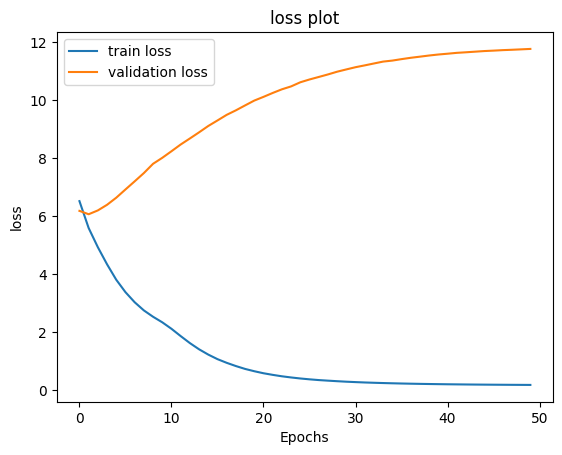

In [14]:
import matplotlib.pyplot as plt
def plot_training_history(history, metric="loss", save_img=True):
    # Plot training history
    plt.title(f"{metric} plot")
    plt.plot(history.history[metric], label=f"train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    # plt.show()
    if save_img:
        plt.savefig(f"/kaggle/working/{metric}_plot.png", dpi=1000)
        
plot_training_history(history)

In [15]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/model_lstm.keras')

# Assuming 'test_data' and 'test_labels' are your features and labels for the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.1458 - loss: 6.7329
Test Loss: 6.664519309997559
Test Accuracy: 0.14553900063037872


### Inference

In [16]:
# Generate next word predictions 
inference_text = "I am happy because"
next_words = 4
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([inference_text])[0] 
    token_list = pad_sequences( 
        [token_list], maxlen=max_sequence_length-1, padding='pre') 
    predicted_probs = model.predict(token_list) 
    predicted_word = tokenizer.index_word[np.argmax(predicted_probs)] 
    inference_text += " " + predicted_word

print(inference_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
I am happy because we are a good
